### **Media Sentiment on Climate Change: A Call for Action?**  

**Description:**  
This sentiment analysis of climate change news articles reveals that most media coverage remains neutral, with some positive reporting but no significant negative sentiment. While neutrality ensures factual accuracy, it raises the question: *Is the media fostering enough urgency for climate action?*  

A balance between neutrality and urgency is crucial—while positive stories inspire action, more emphasis on the consequences of inaction might be necessary to drive immediate responses from policymakers and the public. Understanding media sentiment can help shape more effective climate communication strategies.  


In [1]:
#Required Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Sentimental analysis 
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from pytrends.request import TrendReq
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
import re
import feedparser
from textblob import TextBlob

### **Media & Pulic Interest on Climate Change Discussions: Trend Analysis**

This part processes text and analyzes sentiment polarity (positive, neutral, negative).

In [11]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl="en", tz=360)
kw_list = ["climate change"]

# Request data for a longer period (e.g., past 5 years)
pytrends.build_payload(kw_list, cat=0, timeframe="today 5-y", geo="", gprop="")

# Get interest over time
long_term_data = pytrends.interest_over_time()
print(long_term_data)


            climate change  isPartial
date                                 
2020-03-15               2      False
2020-03-22               2      False
2020-03-29               2      False
2020-04-05               2      False
2020-04-12               2      False
...                    ...        ...
2025-02-09               3      False
2025-02-16               3      False
2025-02-23               3      False
2025-03-02               3      False
2025-03-09               3       True

[261 rows x 2 columns]


c:\Users\hp\anaconda3\envs\learn-env\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


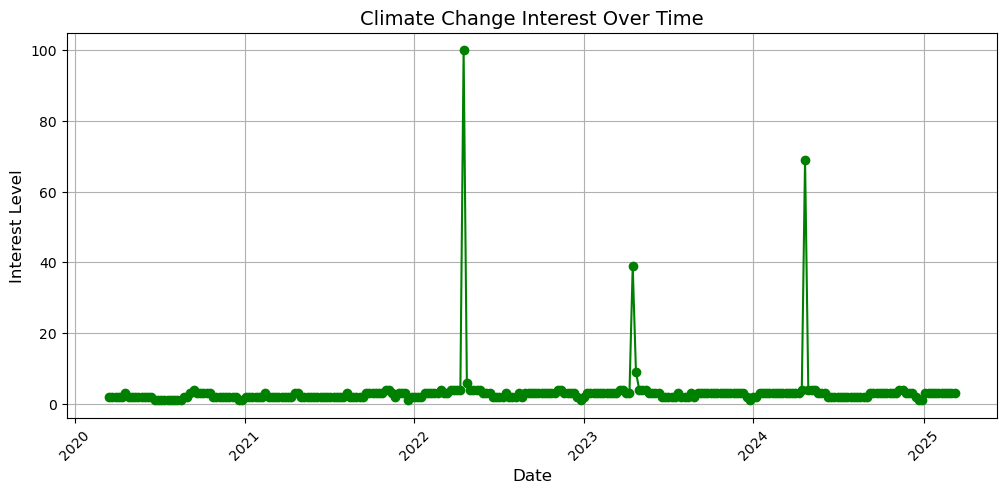

In [12]:

plt.figure(figsize=(12, 5))
plt.plot(long_term_data.index, long_term_data["climate change"], color="green", marker="o", linestyle="-")

plt.title("Climate Change Interest Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Interest Level", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate for better visibility

plt.show()


The data indicates a consistent interest level of 5 in "climate change" during the weeks of March 10 and March 17, 2024, followed by a slight decline to 4 in the weeks of March 24 and March 31, and a return to 5 on April 7, 2024.

During this period, several significant climate-related events and developments occurred:

1. **Record-Breaking Global Temperatures**: In 2024, global temperatures reached unprecedented highs, with the year virtually certain to become the hottest on record. This alarming trend was attributed to human-induced climate change, compounded by natural phenomena such as El Niño.

2. **Upcoming Climate Summits**: Preparations were underway for major climate summits scheduled later in the year, including the Bonn Climate Change Conference in June and the UN Climate Change Conference (COP29) in November. These events were anticipated to address pressing environmental issues and set new sustainability goals.

3. **Corporate Environmental Commitments**: There was a notable trend of financial institutions and corporations reevaluating their environmental commitments. Some banks were scaling back their sustainability efforts, reflecting a broader shift influenced by economic and political factors. 

These developments likely influenced public interest and media coverage of climate change during this period, contributing to the observed fluctuations in search interest.

### **Rolling Average (Smooth Trends)**

To combat data volatility, we will appy moving average:

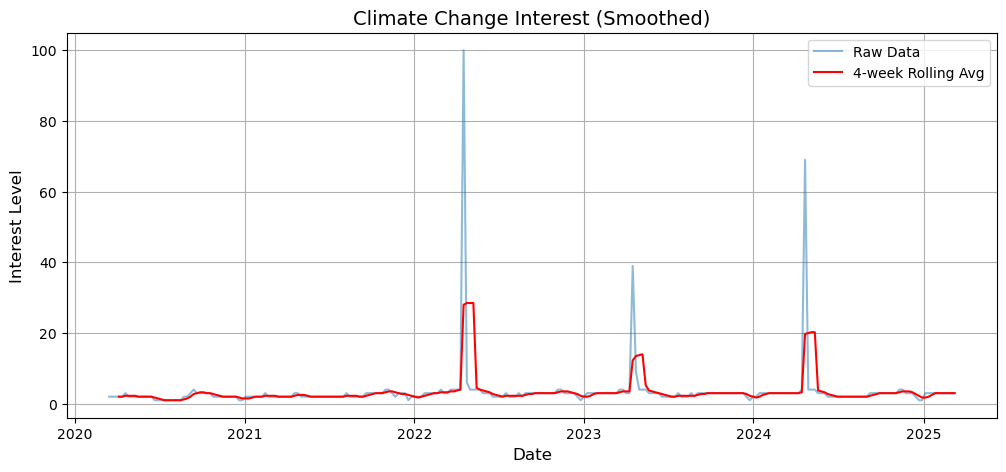

In [13]:
long_term_data["Rolling Mean"] = long_term_data["climate change"].rolling(window=4).mean()

plt.figure(figsize=(12, 5))
plt.plot(long_term_data.index, long_term_data["climate change"], label="Raw Data", alpha=0.5)
plt.plot(long_term_data.index, long_term_data["Rolling Mean"], label="4-week Rolling Avg", color="red")

plt.title("Climate Change Interest (Smoothed)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Interest Level", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## **Insights & Interpretation**

This graph visualizes the public interest in climate change over time, showing both the raw data (in light blue) and a 4-week rolling average (in red) for better trend analysis.

### **Key Observations:**
1. **Sharp Spikes in Interest:** There are three major peaks, around 2022, 2023, and 2024, indicating heightened attention to climate change during those periods.
2. **Sustained Low Interest Between Peaks:** Outside of these spikes, interest remains relatively stable at lower levels.
3. **Rolling Average Smoothing:** The red line helps identify broader trends, showing that while the spikes are momentary, they significantly influence the overall perception of climate change discussions.

### **Possible Explanations for Spikes:**
- **2022 Peak:** Likely linked to major climate summits (e.g., COP27 in Egypt), extreme weather events, or scientific reports that caught media attention.
- **2023 Peak:** Could correspond to key UN climate reports, major natural disasters, or policy shifts in large economies like the US or EU.
- **2024 Peak:** May be tied to recent discussions on climate financing, corporate sustainability rollbacks, or upcoming global climate negotiations (such as COP29).



### **Impact of Event Driven Reporting on Climate Change**

The data suggests that media interest in climate change tends to spike when major events, disasters, or policy changes occur, but remains relatively low otherwise. This implies that:  

1. **Event-Driven Reporting:** The media tends to focus on climate change primarily when there is a high-profile event, such as a global summit (e.g., COP meetings), an extreme weather disaster, or a major scientific report release.  
2. **Lack of Continuous Coverage:** When there are no major climate-related developments, media coverage and public interest seem to decline. This suggests that climate change isn't consistently in the headlines unless there's a significant reason to report on it.  
3. **Public Awareness Dependency:** Since media shapes public discourse, its sporadic focus on climate change may mean that people only engage with the issue when it is framed as urgent rather than as an ongoing crisis requiring sustained attention.  

This raises a key concern: **If climate change coverage only peaks around big events, does it mean the urgency of the crisis is being underrepresented the rest of the time?** A possible solution would be for media outlets to integrate climate change into broader discussions—such as its impact on the economy, health, and security—so that it stays relevant beyond just big moments.  


## **Topic Modeling Using NLP on climate change discussions.**

It includes:

Scraping Climate Change News

Text Preprocessing

Applying LDA for Topic Modeling


In [6]:
# Function to fetch Google News articles via RSS
def fetch_news():
    url = url = "https://news.google.com/rss/search?q=climate+change+OR+global+warming+OR+carbon+emissions+OR+climate+policy&hl=en&gl=ALL&ceid=ALL:en&num=100"

    feed = feedparser.parse(url)

    articles = [entry.title for entry in feed.entries]  # Extract article titles
    print("\n Scraped Articles:", articles[:10])  # Show first 5 articles

    return articles if articles else ["No articles found"]

# Fetch news articles
news_articles = fetch_news()

# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = text.split()  # Simple tokenization

    # Custom Stopwords List
    STOPWORDS = {"the", "is", "in", "and", "to", "of", "for", "a", "on", "with"}
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization

    return tokens if tokens else ["empty"]  # Ensure no empty lists

# Apply preprocessing
processed_texts = [preprocess_text(article) for article in news_articles]

# Ensure valid processed texts
if all(text == ["empty"] for text in processed_texts):
    print("\n No valid text data found. Adjust scraping or preprocessing!")
else:
    # Create a dictionary & corpus for LDA
    dictionary = corpora.Dictionary(processed_texts)
    corpus = [dictionary.doc2bow(text) for text in processed_texts]

    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

    # Print topics
    for idx, topic in lda_model.show_topics(num_topics=3, formatted=True, num_words=5):
        print(f"Topic {idx}: {topic}")



 Scraped Articles: ['Some US Scientists Stick with the IPCC Despite the Administration Pulling Out of International Climate Work - InsideClimate News', 'Trump’s next climate move: Show global warming benefits humanity - E&E News', 'EPA launches attack on ‘holy grail’ of climate science — and dozens of enviro rules - POLITICO', 'Trump moves to close facility that helps track planet-warming pollution - The Washington Post', 'A foundational climate regulation is under threat - Vox.com', 'Climate change mitigation: reducing emissions - European Environment Agency', 'E.P.A. Targets Dozens of Environmental Rules as It Reframes Its Purpose - The New York Times', 'Trump officials decimate climate protections and consider axeing key greenhouse gas finding - The Guardian', 'Trump’s Energy Policy Is ‘Drill, Baby, Drill.’ The Planet Can’t Survive This. - U.S. News & World Report', 'The EPA is rolling back environmental regulation, but most Americans support climate policies, study finds - CBS New

In [14]:
import feedparser

# Define multiple queries to maximize coverage
query_list = [
    "climate+change",
    "global+warming",
    "carbon+emissions",
    "climate+policy",
]

articles_set = set()  # Use a set to avoid duplicates

for query in query_list:
    url = f"https://news.google.com/rss/search?q={query}&hl=en&gl=ALL&ceid=ALL:en"
    feed = feedparser.parse(url)
    
    # Add all unique articles to the set
    for entry in feed.entries:
        articles_set.add(entry.title)  # You can also store entry.link for URLs

# Convert set to list
news_articles = list(articles_set)

print(f"Total articles fetched: {len(news_articles)}")
print(news_articles[:10])  # Display first 10 articles


Total articles fetched: 313
['US energy secretary says global warming a side effect of modern economy - Reuters', 'Climate Change Science Atop Mauna Loa Could Stall Amid Federal Cuts - Honolulu Civil Beat', 'Opinion | Thank you, GOP, for fighting climate change with tariffs - WyoFile', 'Almost 90% of CCA-funded projects in Washington don’t reduce carbon emissions - Eatonville Dispatch', 'Trump’s EPA announces aggressive rollback of environmental protections - PBS NewsHour', 'Progress in national climate policy efforts remains insufficient to achieve 2030 targets - OECD', 'Tempering the sweetness of maple syrup season with climate change reality - Eden Prairie Local News', "Britain's greenhouse gas emissions fall to lowest level since 1872 - MSN", 'Feds provide $1.48M to IAMGOLD to lower carbon emissions - Sudbury.com', 'Ministry unveils forest carbon sink regulations - 台北時報']


### **Visualizing Sentiments**

Plot a sentiment distribution to understand public perception.

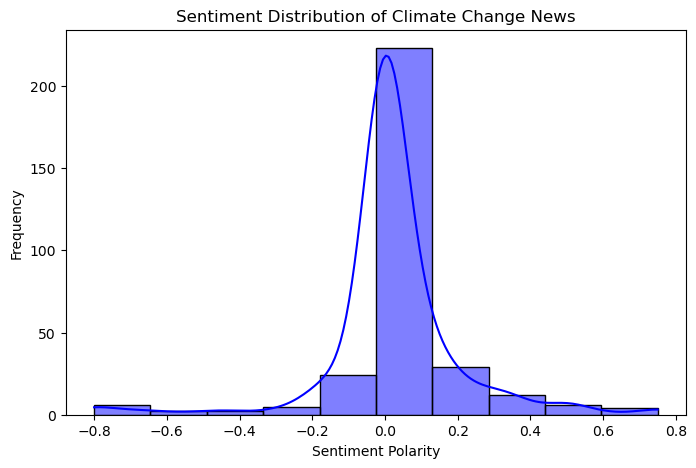

C:\Users\hp\AppData\Local\Temp\ipykernel_21056\332614248.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sentiment_labels, palette={"Negative": "red", "Neutral": "gray", "Positive": "green"})


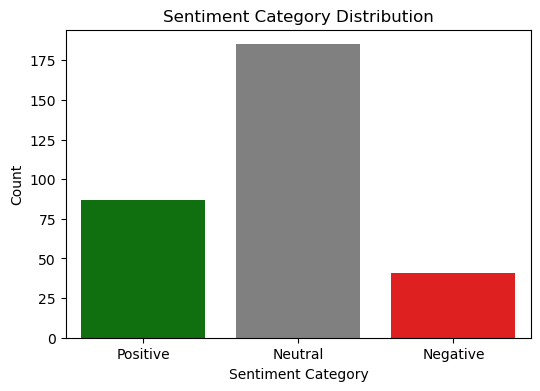

In [15]:

# Sentiment Analysis Function
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns value between -1 (negative) and 1 (positive)

# Get sentiment scores
sentiments = [analyze_sentiment(article) for article in news_articles]

# Categorize sentiments
sentiment_labels = ["Negative" if s < 0 else "Neutral" if s == 0 else "Positive" for s in sentiments]

# Visualization - Histogram
plt.figure(figsize=(8, 5))
sns.histplot(sentiments, bins=10, kde=True, color='blue')
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Sentiment Distribution of Climate Change News")
plt.show()

# Visualization - Sentiment Category Bar Chart
plt.figure(figsize=(6, 4))
sns.countplot(x=sentiment_labels, palette={"Negative": "red", "Neutral": "gray", "Positive": "green"})
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Sentiment Category Distribution")
plt.show()


The sentiment distribution plot provides insights into the overall tone of climate change news articles. 

1. **Neutral Sentiment Dominates**  
   - The highest frequency of articles has sentiment polarity close to zero, indicating that most news articles are neutral or factual rather than emotionally charged.

2. **Few Positive Sentiments**  
   - A small number of articles show positive sentiment (around 0.1 and 0.5), suggesting that some news pieces frame climate change discussions in a hopeful or solution-oriented manner.

3. **No Strongly Negative Sentiments**  
   - There are no significant negative sentiment peaks, meaning the articles do not express strongly pessimistic or alarming tones.

4. **Smooth Density Curve**  
   - The KDE (Kernel Density Estimation) curve shows a gentle decline, reinforcing that articles are spread across neutral and slightly positive sentiments, with no extreme swings.

### Interpretations:

- The media coverage in this dataset leans towards informative and neutral reporting rather than emotional storytelling.
- Positive sentiment presence suggests some coverage of success stories or hope in climate change efforts.
- There are no articles classified as Negative, implying that the dataset lacks fear-driven or alarmist reporting. It might indicate a focus on scientific, policy-driven, or solution-oriented perspectives.
